## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import linregress, uniform
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## 2. Load and Inspect Data

### 2.1. Import and Overview

In [3]:
df = pd.read_csv('data/lead_scoring.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
# Describing data
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


### 2.2. Checking `null` values

Some columns have 'Select' value => determine missing

In [6]:
df.replace('Select', np.nan, inplace=True)

In [7]:
#Column wise null values in train data set 
null_perc = pd.DataFrame(round((df.isnull().sum())*100/df.shape[0],2)).reset_index()
null_perc.columns = ['Column Name', 'Null Values Percentage']
null_value = pd.DataFrame(df.isnull().sum()).reset_index()
null_value.columns = ['Column Name', 'Null Values']
null_lead = pd.merge(null_value, null_perc, on='Column Name')
null_lead.sort_values("Null Values", ascending = False)

,Column Name,Null Values,Null Values Percentage
13,How did you hear about X Education,7250,78.46
28,Lead Profile,6855,74.19
25,Lead Quality,4767,51.59
31,Asymmetrique Profile Index,4218,45.65
30,Asymmetrique Activity Index,4218,45.65
32,Asymmetrique Activity Score,4218,45.65
33,Asymmetrique Profile Score,4218,45.65
29,City,3669,39.71
12,Specialization,3380,36.58
24,Tags,3353,36.29


**Note**: should drop columns with majority of null values:
 Columns with >45% null values:
- `How did you hear about X Education` (78.46%)
- `Lead Profile` (74.19%)
- `Lead Quality` (51.59%)
- `Asymmetrique Profile Index` (45.65%)
- `Asymmetrique Activity Index` (45.65%)
- `Asymmetrique Activity Score` (45.65%)
- `Asymmetrique Profile Score` (45.65%)


### 2.3. Checking Unique ID

In [8]:
print("Total number of duplicate values in Prospect ID column :" , df.duplicated(subset = 'Prospect ID').sum())
print("Total number of duplicate values in Lead Number column :" , df.duplicated(subset = 'Lead Number').sum())

Total number of duplicate values in Prospect ID column : 0
Total number of duplicate values in Lead Number column : 0


**Note**: `Prospect ID` and `Lead Number` are unique indicators => drop

## 3. Data Cleaning


#### 3.1. Remove Unnecessary Columns
Drop the columns that are identified above.

`Lead Quality`, `Asymmetrique`  etc. are *created by the sales team once they contact the potential lead* => not be available for the model building.


In [9]:
cols_to_drop = ['Prospect ID','Lead Number','How did you hear about X Education','Lead Profile',
                'Lead Quality','Asymmetrique Profile Score','Asymmetrique Activity Score',
               'Asymmetrique Activity Index','Asymmetrique Profile Index']

In [10]:
df.drop(columns=cols_to_drop, inplace=True)
len(df.columns)

28

#### 3.2. Identifying Columns Type 
Split columns to *Categorical* and *Numerical*

In [11]:
categorical_col = df.select_dtypes(exclude =["number"]).columns.values
numerical_col = df.select_dtypes(include =["number"]).columns.values
print("CATEGORICAL FEATURES : \n {} \n\n".format(categorical_col))
print("NUMERICAL FEATURES : \n {} ".format(numerical_col))

CATEGORICAL FEATURES : 
 ['Lead Origin' 'Lead Source' 'Do Not Email' 'Do Not Call' 'Last Activity'
 'Country' 'Specialization' 'What is your current occupation'
 'What matters most to you in choosing a course' 'Search' 'Magazine'
 'Newspaper Article' 'X Education Forums' 'Newspaper'
 'Digital Advertisement' 'Through Recommendations'
 'Receive More Updates About Our Courses' 'Tags'
 'Update me on Supply Chain Content' 'Get updates on DM Content' 'City'
 'I agree to pay the amount through cheque'
 'A free copy of Mastering The Interview' 'Last Notable Activity'] 


NUMERICAL FEATURES : 
 ['Converted' 'TotalVisits' 'Total Time Spent on Website'
 'Page Views Per Visit'] 


#### 3.3. Handle Categorical Missing Values

##### Utils

In [12]:
# Checking unique values and null values for the categorical columns
def cat_info(df, categorical_column):
    df_result = pd.DataFrame(columns=["columns","values","unique_values","null_values","null_percent"])
    
    for value in categorical_column:
        df_temp = pd.DataFrame({
            "columns": [value],
            "values": [df[value].unique()],
            "unique_values": [df[value].nunique()],
            "null_values": [df[value].isna().sum()],
            "null_percent": [(df[value].isna().sum()/len(df)*100).round(1)]
        })
        df_result = pd.concat([df_result, df_temp], ignore_index=True)
    
    df_result.sort_values("null_values", ascending=False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result


##### Analysis

In [13]:
df_cat = cat_info(df, categorical_col)
df_cat

/tmp/ipykernel_571644/1865801373.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, df_temp], ignore_index=True)


,values,unique_values,null_values,null_percent
columns,,,,
City,"[nan, Mumbai, Thane & Outskirts, Other Metro C...",6,3669,39.7
Specialization,"[nan, Business Administration, Media and Adver...",18,3380,36.6
Tags,"[Interested in other courses, Ringing, Will re...",26,3353,36.3
What matters most to you in choosing a course,"[Better Career Prospects, nan, Flexibility & C...",3,2709,29.3
What is your current occupation,"[Unemployed, Student, nan, Working Professiona...",6,2690,29.1
Country,"[nan, India, Russia, Kuwait, Oman, United Arab...",38,2461,26.6
Last Activity,"[Page Visited on Website, Email Opened, Unreac...",17,103,1.1
Lead Source,"[Olark Chat, Organic Search, Direct Traffic, G...",21,36,0.4
Lead Origin,"[API, Landing Page Submission, Lead Add Form, ...",5,0,0.0


##### 3.3.1. Dropping single category columns
**Note**: Some columns only have one category => *Drop as adding no values to the models*


In [14]:
cat_cols_to_drop = df_cat[df_cat['unique_values']==1].index.values.tolist() 
cat_cols_to_drop

['I agree to pay the amount through cheque',
 'Get updates on DM Content',
 'Update me on Supply Chain Content',
 'Receive More Updates About Our Courses',
 'Magazine']

In [15]:
# Dropping columns
df.drop(columns=cat_cols_to_drop, inplace=True)

In [16]:
# Expand the drop columns
cols_to_drop = cols_to_drop + cat_cols_to_drop

# The remaining cat columns
categorical_col = [col for col in categorical_col if col not in cat_cols_to_drop]

In [20]:
# reexamine the categorical columns
df_cat = cat_info(df, categorical_col)
df_cat

/tmp/ipykernel_571644/1865801373.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, df_temp], ignore_index=True)


,values,unique_values,null_values,null_percent
columns,,,,
City,"[nan, Mumbai, Thane & Outskirts, Other Metro C...",6,3669,39.7
Specialization,"[nan, Business Administration, Media and Adver...",18,3380,36.6
Tags,"[Interested in other courses, Ringing, Will re...",26,3353,36.3
What matters most to you in choosing a course,"[Better Career Prospects, nan, Flexibility & C...",3,2709,29.3
What is your current occupation,"[Unemployed, Student, nan, Working Professiona...",6,2690,29.1
Country,"[nan, India, Russia, Kuwait, Oman, United Arab...",38,2461,26.6
Last Activity,"[Page Visited on Website, Email Opened, Unreac...",17,103,1.1
Lead Source,"[Olark Chat, Organic Search, Direct Traffic, G...",21,36,0.4
Lead Origin,"[API, Landing Page Submission, Lead Add Form, ...",5,0,0.0


##### 3.3.2. Other Categorical Columns

`Tags`

In [26]:
df['Tags'].value_counts()

Tags
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to O

**Note**: Missing values can be considered as 'Unknown'

`Lead Source`

In [34]:
df['Lead Source'].value_counts()

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: count, dtype: int64

**Note**: Missing values are minors => Impute with the most occurence 'Google'

`Last Activity`

In [35]:
df['Last Activity'].value_counts()

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: count, dtype: int64

**Note**: Missing values are minors => Impute with the most occurence 'Email Opened'

`Country`

In [18]:
df['Country'].value_counts()

Country
India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Nigeria                    4
Germany                    4
Canada                     4
Sweden                     3
Italy                      2
Belgium                    2
Ghana                      2
Philippines                2
Netherlands                2
China                      2
Asia/Pacific Region        2
Bangladesh                 2
Uganda                     2
Russia                     1
Sri Lanka                  1
Tanzania                   1
Kenya                      1
Malaysia                   1
Liberia                    1
Denmar

**Note**: 
- Mostly in India 
=> droppable with the fact that it also has many 'Select' Value

 `City`

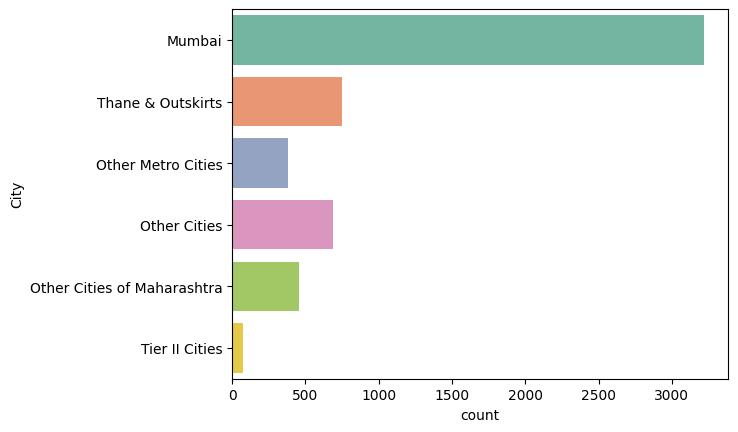

In [17]:
ax = sns.countplot(df, y = 'City', hue = 'City', legend=False, palette = 'Set2')
plt.show()

**Note**: 
- The data is *heavily skewed* => can not impute 'Select' (missing) with any 
=> droppable due to the fact that this is online service and most of the clients are from India


In [19]:
#### add to cols_to_drop
cols_to_drop = cols_to_drop + ['City', 'Country']

 `Specialization`

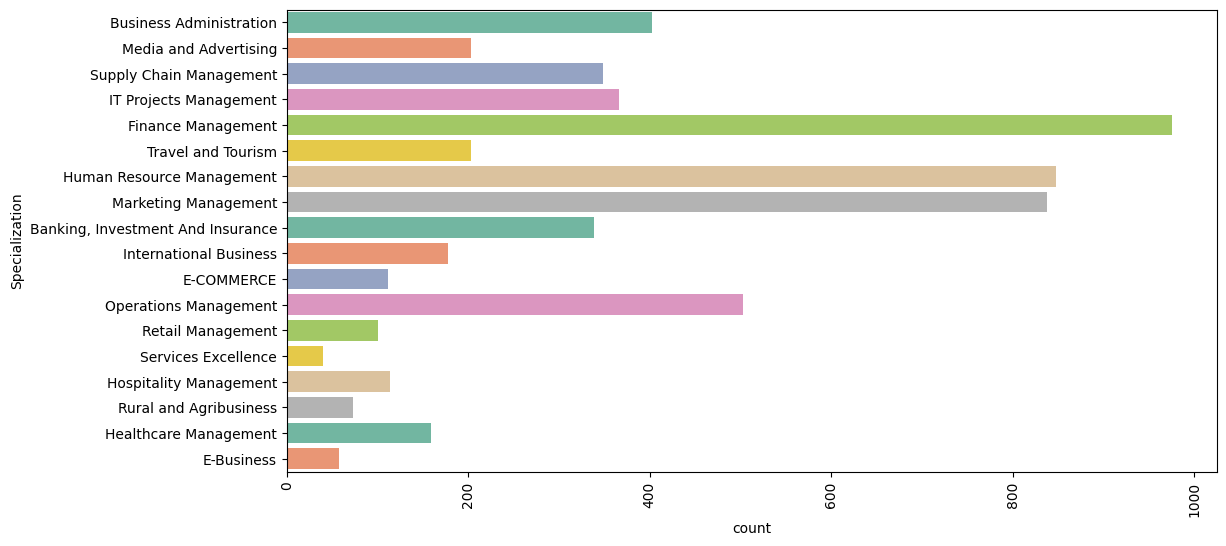

In [25]:
plt.figure(figsize=(12,6))
ax = sns.countplot(df, y = 'Specialization', hue = 'Specialization', legend=False, palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

**Note**: 'Select' as missing value might be considered as 'Unknown' 


`Occupation`

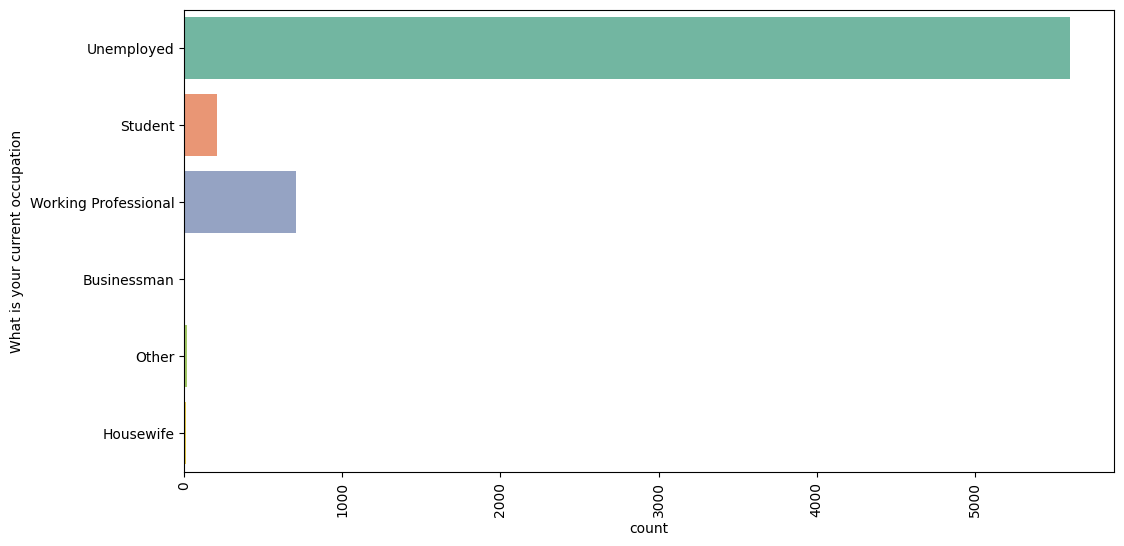

In [24]:
plt.figure(figsize=(12,6))
ax = sns.countplot(df, y = 'What is your current occupation', hue = 'What is your current occupation', legend=False, palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

**Note**: 'Select' as missing value might be considered as 'Unknown' 


 `What matters most to you in choosing a course`

In [21]:
df['What matters most to you in choosing a course'].value_counts()

What matters most to you in choosing a course
Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

**Note**: Heavily skewed =>> dropable

In [22]:
cols_to_drop = cols_to_drop + ['What matters most to you in choosing a course']

#### 3.4. Handle Numerical Missing Values
No insights just yet => consider later

In [32]:
### remove Converted column
numerical_col = numerical_col[numerical_col != 'Converted']

In [33]:
cols_to_drop

['Prospect ID',
 'Lead Number',
 'How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'I agree to pay the amount through cheque',
 'Get updates on DM Content',
 'Update me on Supply Chain Content',
 'Receive More Updates About Our Courses',
 'Magazine',
 'City',
 'Country',
 'What matters most to you in choosing a course']

### 4. EDA

#### 4.1. Categorical Variables

#### 4.2. Numerical Variables 

In [7]:
train, test = train_test_split(df, test_size=.2, random_state=12, stratify=df['Converted'])
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7392, 37)
test shape: (1848, 37)


**Create a transformer for later pipeline**

In [13]:
def drop_cols(df):
    return df.drop(columns=cols_to_drop, inplace=True)

drop_cols_transformer = FunctionTransformer(drop_cols)

In [ ]:
drop_cols_transformer

In [ ]:
# replace 'Lead Source' missing values with 'Google'
df['Lead Source'].replace(np.nan, 'Google', inplace=True)

# replace 'Last Activity' missing values with 'Email Opened'
df['Last Activity'].replace(np.nan, 'Email Opened', inplace=True)

# replace the rest missing values with 'Unknown'
df.replace(np.nan, 'Unknown', inplace=True)
